# Compare PF-CONUS2 WTD to long-term WTD average observations
D. Tijerina, 7/2023

This script reads in WTD observations queried from Hydrodata and Fan et al. and compares to PF-CONUS2 WTD. The notebook is broken up into these sections:  
1. Read in WTD observations and metadata; organize into pandas dataframes
2. Read in CONUS2 WTD and extract indices for CONUS2 grid cells that are common to the WTD observations;  organize all data
3. Compute statistics between PF-CONUS2 and WTD observations
4. Create summary plots, maps


Inputs:
- WTD Metadata csv file of stations from a Hydrodata query (from point_observations.ipynb)
- WTD Observation data csv file of stations from a Hydrodata query (from point_observations.ipynb)

Outputs:
- Matched ParFlow WTD csv
- Rematched Metadata file csv
- Rematched observation file csv
- Summary station SNOTEL csv containing station info, CONUS x and y, averages, statistics
- Summary plots/maps

Notes: 


In [1]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

##### Change paths to directories, run information...

In [2]:
### Directory where model output and observation CSVs live
directory_out = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages'
organized_dir = './Organized_steady-state_WTD'

### Where you want to save plots, etc. to
#plot_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Figures' # verde
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Figures' # cheyenne 
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/WTD/steady_state' # hydrodata
print(f'Figures saving to: {plot_dir}')


### need to change water year and number of days
water_year = 2003
no_days = 364
variable = 'WTD'

### CONUS2 domain
ny = 3256
nx = 4442

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/WTD/steady_state


##### Names of observation csv files, these are usually saved from Hydrodata

In [3]:
### Files for observations from Hydrodata
data_file = 'Hydrodata_wtd_obs_instantaneous_instantaneous_WY2003.csv' 
metadata_file = 'Hydrodata_wtd_metadata_instantaneous_instantaneous_WY2003.csv'

##### Name of path and file name of PFB reading in

In [4]:
# path to daily forcing PFB files
pfb_read_path = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages'
# This is the partial name of the pfb, without the timestamp or .pfb file extension
# (for example, 'NLDAS.APCP.daily.sum.008.pfb' -> 'NLDAS.APCP.daily.sum')
pfb_name = f'{variable}.2003.daily' 
print(pfb_name)

WTD.2003.daily


##### Create file names for all files you will save out
These include:
- CSV of ParFlow or CW3E modeled values from pfb at station-matched CONUS2 x, y
- Rematched observation csv file (this is a reorganized version of `data_file`
- Rematched observation metadata csv file (this is a reorganized version of `metadata_file`
- Summary statistics csv with station info and stats for each station

In [5]:
### Name files you will save out
# names of csv files for model and observations that contain the same stations
pf_matched_csv = f'PF_Daily_matched_CONUS2_{variable}_{water_year}.csv'
obs_matched_csv = f'OBS_Daily_matched_CONUS2_{variable}_{water_year}.csv'
metadata_matched_csv = f'OBS_metadata_matched_CONUS2_{variable}_{water_year}.csv'
# summary stats
summary_stats_csv = f'Summary_Stations_CONUS2_{variable}_WY{water_year}.csv'
print(summary_stats_csv)

Summary_Stations_CONUS2_WTD_WY2003.csv


##### Other things that likely need to be changed
- names of plots saved out  are named within in the plotting function
- same for some specifics of the plot titles

##### Add CONUS2 mask information to mask simulated WTD

In [6]:
mask_tif = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
print(type(mask_tif))
mask_array = np.array(mask_tif)
print(type(mask_array))

# Make copy of mask with nan's in the inactive domain
nan_mask = np.copy(mask_array)
nan_mask[nan_mask == 0.0] = 'nan'
np.unique(nan_mask)

<class 'PIL.TiffImagePlugin.TiffImageFile'>
<class 'numpy.ndarray'>


array([ 1., nan], dtype=float32)

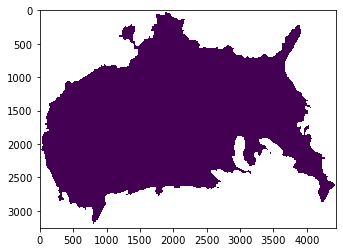

In [7]:
# flip the nan mask so that it is the correct orientation compared to the CONUS2 files
nan_mask_flip = np.flipud(nan_mask)
plt.imshow(nan_mask_flip)

# 1. Read in observations and organize

### WTD

In [8]:
obs_data = pd.read_csv(f'{organized_dir}/{data_file}', index_col=['site_id'])
obs_data = obs_data.drop(columns=['Unnamed: 0'])

#constrain observations to include WTD < 300m and only positive values
obs_data = obs_data.loc[(obs_data['wtd']>0.0)]
obs_data = obs_data.loc[(obs_data['wtd']<300)]
obs_data = obs_data.drop(columns=['num_obs', 'pumping_status', 'date'])
obs_data

,wtd
site_id,
251241080385302,0.271272
251922080340701,0.277368
251922080340701,0.371856
251922080340701,0.518160
251922080340701,0.484632
...,...
485907116294701,1.804416
485907116294701,2.063496
485907116294701,2.331720


In [9]:
obs_data = obs_data.groupby('site_id').mean()
obs_data

,wtd
site_id,
251241080385302,0.271272
251922080340701,0.393573
252007080335701,0.585978
252243080335501,0.338328
252332080300501,0.969264
...,...
485904116303701,2.360981
485904116303702,2.670175
485906116313101,1.941068


In [10]:
metadata = pd.read_csv(f'{organized_dir}/{metadata_file}', index_col=['site_id'])
metadata  = metadata.drop(columns=['Unnamed: 0'])
# also remove the sites with WTD less than 0 and duplicated site ids
metadata = metadata[metadata.index.isin(obs_data.index)]
metadata = metadata[~metadata.index.duplicated(keep='first')]

# add number of observations column from the obs_data df
# metadata['num_obs'] = obs_data['num_obs']
# metadata['pumping_status'] = obs_data['pumping_status']
# metadata['date'] = obs_data['date']


metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,conus1_x,conus1_y,conus2_x,conus2_y
site_id,,,,,,,,,,,,,,,,,,,,,
251241080385302,groundwater well,USGS,G -3763,2.512411e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.210000,-80.647778,FL,3090202.0,...,112BSCNN,NaN,22.40,NaN,NaN,NaN,NaN,NaN,3880.0,209.0
251922080340701,groundwater well,USGS,G -1251,2.519221e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.321083,-80.565750,FL,3090202.0,...,112BSCNN,U,59.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,223.0
252007080335701,groundwater well,USGS,G -3336,2.520071e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.337806,-80.565639,FL,3090202.0,...,112BSCNN,U,38.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,224.0
252243080335501,groundwater well,USGS,G -3619,2.522431e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.378972,-80.565361,FL,3090202.0,...,112BSCNN,U,12.00,12.0,A,2080-00200,NaN,NaN,3885.0,229.0
252332080300501,groundwater well,USGS,G -3355,2.523321e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.393306,-80.500917,FL,3090202.0,...,112BSCNN,U,13.00,NaN,NaN,2080-00200,NaN,NaN,3891.0,232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485904116303701,groundwater well,USGS,65N 01W 18DAB1,4.859041e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.984464,-116.511481,ID,17010104.0,...,NaN,NaN,27.00,28.0,S,ID-02-05101,381.0,1885.0,844.0,2801.0
485904116303702,groundwater well,USGS,65N 01W 18DAB2,4.859041e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.984464,-116.511481,ID,17010104.0,...,NaN,NaN,52.16,55.0,S,ID-02-05101,381.0,1885.0,844.0,2801.0
485906116313101,groundwater well,USGS,65N 01W 18CBB1,4.859061e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.985183,-116.526367,ID,17010104.0,...,NaN,NaN,27.35,28.0,S,ID-02-05101,380.0,1885.0,843.0,2802.0


In [11]:
if len(obs_data)!=len(metadata):
    print('CHECK THAT METADATA AND OBSERVATIONS HAVE THE SAME SITE IDS!')
else: 
    print('Metadata and Observation dataframes have same number of site ids.')

Metadata and Observation dataframes have same number of site ids.


# 2. Read in PFBs and organize

#### Read in pfb and extract data at each CONUS2 index pair included in the observations/metadata files

In [12]:
# read daily variable for no_days
pf_full_array = np.zeros((no_days, ny, nx))
for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    ### CHECK THIS PATH TO CONFIRM CORRECT OBS FILE ###
    pf_pfb = np.squeeze(read_pfb(f'{pfb_read_path}/{pfb_name}.{step}.pfb'))
    pf_full_array[i,...] = pf_pfb
    print(f'reading {variable} for day {step}')

reading WTD for day 001
reading WTD for day 002
reading WTD for day 003
reading WTD for day 004
reading WTD for day 005
reading WTD for day 006
reading WTD for day 007
reading WTD for day 008
reading WTD for day 009
reading WTD for day 010
reading WTD for day 011
reading WTD for day 012
reading WTD for day 013
reading WTD for day 014
reading WTD for day 015
reading WTD for day 016
reading WTD for day 017
reading WTD for day 018
reading WTD for day 019
reading WTD for day 020
reading WTD for day 021
reading WTD for day 022
reading WTD for day 023
reading WTD for day 024
reading WTD for day 025
reading WTD for day 026
reading WTD for day 027
reading WTD for day 028
reading WTD for day 029
reading WTD for day 030
reading WTD for day 031
reading WTD for day 032
reading WTD for day 033
reading WTD for day 034
reading WTD for day 035
reading WTD for day 036
reading WTD for day 037
reading WTD for day 038
reading WTD for day 039
reading WTD for day 040
reading WTD for day 041
reading WTD for 

In [13]:
# compute annual mean
# axis = 0 ensures that you are taking the daily mean of the array (so along the first dimension axis (364))
annual_mean = np.mean(pf_full_array, axis = 0)*nan_mask_flip
annual_total = pf_full_array.sum(axis=0)*nan_mask_flip
write_pfb(f'{organized_dir}/PF_{variable}.{water_year}.gridded_annual_mean.pfb',annual_mean,dist=False)
write_pfb(f'{organized_dir}/PF_{variable}.{water_year}.gridded_annual_total.pfb',annual_total,dist=False)

(3256, 4442)

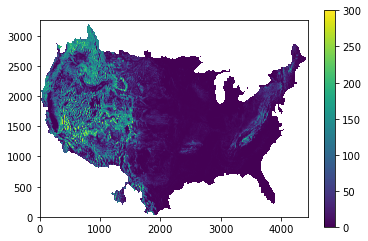

In [11]:
annual_mean_pfb = np.squeeze(read_pfb(f'{organized_dir}/PF_{variable}.{water_year}.gridded_annual_mean.pfb'))
plt.imshow(annual_mean_pfb, origin='lower')
plt.colorbar()
annual_mean_pfb.shape

# Match WTD observations to CONUS2 indices

In [15]:
# make CONUS2 x and y into arrays for the for loop
conusy = np.asarray(metadata['conus2_y'],dtype = 'int')
conusx = np.asarray(metadata['conus2_x'],dtype = 'int')

In [18]:
# Set up arrays 
#pf_full_array = np.zeros((no_days, ny, nx))
pf_matched = np.zeros(obs_data.shape)

for j in range(len(obs_data.index)):
    #print(obs_data.index)
    if conusy[j] < 0:
        pf_matched[j] = 'nan'
        #print('Gage is outside of CONUS2 range')
    else:
        pf_matched[j] = annual_mean[conusy[j], conusx[j]]
        #print(f'Finding value in CONUS2 grid {conusy[j]}, {conusx[j]}')

In [19]:
# Organize PF daily matched array with the same index and dates as the obs_data
pf_match_df = pd.DataFrame(pf_matched)
pf_match_df = pf_match_df.set_index(obs_data.index)
column_headers = list(obs_data.columns.values)
pf_match_df.columns = column_headers
pf_match_df

,wtd
site_id,
251241080385302,0.680495
251922080340701,0.793044
252007080335701,0.829416
252243080335501,0.766528
252332080300501,0.569691
...,...
485904116303701,0.000182
485904116303702,0.000182
485906116313101,0.000232


In [20]:
# drop any na's
pf_match_df_new = pf_match_df.dropna()
pf_match_df_new

,wtd
site_id,
251241080385302,0.680495
251922080340701,0.793044
252007080335701,0.829416
252243080335501,0.766528
252332080300501,0.569691
...,...
485904116303701,0.000182
485904116303702,0.000182
485906116313101,0.000232


In [21]:
# parse down observation df to include the same stations as the final ParFlow matched df
obs_data_new = obs_data[obs_data.index.isin(pf_match_df_new.index)]
obs_data_new

,wtd
site_id,
251241080385302,0.271272
251922080340701,0.393573
252007080335701,0.585978
252243080335501,0.338328
252332080300501,0.969264
...,...
485904116303701,2.360981
485904116303702,2.670175
485906116313101,1.941068


In [22]:
# parse down metadata df to include the same stations as the final ParFlow matched df
metadata_new = metadata[metadata.index.isin(pf_match_df_new.index)]
metadata_new

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,conus1_x,conus1_y,conus2_x,conus2_y
site_id,,,,,,,,,,,,,,,,,,,,,
251241080385302,groundwater well,USGS,G -3763,2.512411e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.210000,-80.647778,FL,3090202.0,...,112BSCNN,NaN,22.40,NaN,NaN,NaN,NaN,NaN,3880.0,209.0
251922080340701,groundwater well,USGS,G -1251,2.519221e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.321083,-80.565750,FL,3090202.0,...,112BSCNN,U,59.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,223.0
252007080335701,groundwater well,USGS,G -3336,2.520071e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.337806,-80.565639,FL,3090202.0,...,112BSCNN,U,38.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,224.0
252243080335501,groundwater well,USGS,G -3619,2.522431e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.378972,-80.565361,FL,3090202.0,...,112BSCNN,U,12.00,12.0,A,2080-00200,NaN,NaN,3885.0,229.0
252332080300501,groundwater well,USGS,G -3355,2.523321e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.393306,-80.500917,FL,3090202.0,...,112BSCNN,U,13.00,NaN,NaN,2080-00200,NaN,NaN,3891.0,232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485904116303701,groundwater well,USGS,65N 01W 18DAB1,4.859041e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.984464,-116.511481,ID,17010104.0,...,NaN,NaN,27.00,28.0,S,ID-02-05101,381.0,1885.0,844.0,2801.0
485904116303702,groundwater well,USGS,65N 01W 18DAB2,4.859041e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.984464,-116.511481,ID,17010104.0,...,NaN,NaN,52.16,55.0,S,ID-02-05101,381.0,1885.0,844.0,2801.0
485906116313101,groundwater well,USGS,65N 01W 18CBB1,4.859061e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.985183,-116.526367,ID,17010104.0,...,NaN,NaN,27.35,28.0,S,ID-02-05101,380.0,1885.0,843.0,2802.0


In [23]:
# save the newly matched daily average, observations, and metadata as csv's
pf_match_df_new.to_csv(f'{organized_dir}/{pf_matched_csv}', sep = ",")
obs_data_new.to_csv(f'{organized_dir}/{obs_matched_csv}', sep = ",")
metadata_new.to_csv(f'{organized_dir}/{metadata_matched_csv}', sep = ",")

In [40]:
longTermMean = np.squeeze(read_pfb(f'{organized_dir}/gridded_WTD_mean_obs_CONUS2.pfb'))
longTermMean.shape

(3256, 4442)

# 3. Compute and save stats

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from scipy import stats

In [ ]:
### read in CONUS2 daily matched csv
# Precipitation in mm (OR mm/s???)
pfdata = pd.read_csv(f'{organized_dir}/{pf_matched_csv}',index_col=['site_id'])
print(pfdata.shape)
pfdata.head()

In [ ]:
### read in matched csv
snotel_data= pd.read_csv(f'{organized_dir}/{obs_matched_csv}',index_col=['site_id']) 
print(snotel_data.shape)
snotel_data.head()

In [ ]:
### read in SNOTEL Temperature metadata for all stations 
snotel_metadata = pd.read_csv(f'{organized_dir}/{metadata_matched_csv}',index_col=['site_id'])
print(snotel_metadata.shape)
snotel_metadata.head()

In [ ]:
# set up DF for daily stats, index is station site_id
stats_df = pd.DataFrame(index = snotel_metadata.index, columns = ['site_name', 'state', 'latitude', 'longitude', 'conus2_x','conus2_y']) 
#, 'bias', 'pbias','absrelbias', 'relbias','srho', 'r2', 'mse', 'rmse', 'nse',scaled RMSE

stats_df['site_name'] = snotel_metadata['site_name']
stats_df['state'] = snotel_metadata['state']
stats_df['latitude'] = snotel_metadata['latitude']
stats_df['longitude'] = snotel_metadata['longitude']
stats_df['conus2_x'] = snotel_metadata['conus2_x'].astype(int)
stats_df['conus2_y'] = snotel_metadata['conus2_y'].astype(int)
print(stats_df.shape)
stats_df.head()

In [ ]:
# compute annual average for observations
# calculate "yearly average" by dividing annual sum by num_obs (note not all sites have 365 observations)
snotel_Temp_sum = snotel_data.sum(axis=1)

### CHANGE THE NAMES OF THESE COLUMN HEADERS ###
stats_df['SNOTEL_meanTotal_P_mm'] = snotel_Temp_sum/snotel_metadata.num_obs
stats_df['CW3E_meanTotal_P_mm'] = np.mean(pfdata, axis = 1)

In [ ]:
# Set up array for stats
r2_daily = np.zeros(len(pfdata.index))
srho_daily = np.zeros(len(pfdata.index))
pval_daily = np.zeros(len(pfdata.index))
mse_daily = np.zeros(len(pfdata.index))
rmse_daily = np.zeros(len(pfdata.index))
nse_daily = np.zeros(len(pfdata.index))
bias_daily = np.zeros(len(pfdata.index))
pbias_daily = np.zeros(len(pfdata.index))
pbias_test = np.zeros(len(pfdata.index))
absrelbias_daily = np.zeros(len(pfdata.index))
relbias_daily = np.zeros(len(pfdata.index))
r2_daily.shape

In [ ]:
for g in range(len(pfdata.index)):
    gage = pfdata.index[g]
    absrelbias_daily[g] = abs((pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()) #absolute relative bias
    bias_daily[g] = (pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()
    pbias_daily[g] = bias_daily[g]*100
    srho_daily[g], pval_daily[g] = stats.spearmanr(snotel_data.loc[gage], pfdata.loc[gage])
    # mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #rmse_daily[g] = sqrt(mean_squared_error(snotel_data.loc[gage], pfdata.loc[gage]))
    #r2_daily[g] = r2_score(snotel_data.loc[gage], pfdata.loc[gage])

In [ ]:
# assign arrays to pandas columns in stats_df
stats_df['absrelbias'] = absrelbias_daily
stats_df['bias'] = bias_daily
stats_df['pbias'] = pbias_daily
stats_df['srho'] = srho_daily
# stats_df['r2'] = r2_daily
# stats_df['rmse'] = rmse_daily
# stats_df['mse'] = mse_daily

In [ ]:
stats_df.head()

In [ ]:
stats_df.to_csv(f'{organized_dir}/{summary_stats_csv}')

# 4. Plotting Results

In [8]:
#from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd
from PIL import Image
#from mpl_toolkits.basemap import Basemap as Basemap

In [9]:
# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/hydrodata/temp/CONUS2_transfers/CONUS2/CONUS2_from_ucsm0002/domain_files/CONUS2_outline_with_HUC2_noSqrBorder.png')

In [10]:
obs = pd.read_csv(f'{organized_dir}/{obs_matched_csv}',index_col=['site_id'])
metadata = pd.read_csv(f'{organized_dir}/{metadata_matched_csv}',index_col=['site_id'])
pf_wtd_matched = pd.read_csv(f'{organized_dir}/{pf_matched_csv}',index_col=['site_id'])

In [33]:
pf_wtd_matched.wtd.mean()

6.462237608379494

In [34]:
obs.wtd.max()
obs.wtd.mean()

27.739482858010234

In [35]:
np.nanmean(longTermMean)

18.622271780212753

In [78]:
# # Read in CONUS2 mask for map plot border
# CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
# #CONUS2_mask = Image.open('/home/dtt2/CONUS2/shape_files/CONUS2_HUC2_boundaries_clipped.tif')
# mask_array = np.array(CONUS2_mask)

In [ ]:
### read in summary stats (from section 3)
stats_df = pd.read_csv(f'{organized_dir}/{summary_stats_csv}',index_col=['site_id']) 
stats_df.head()

### Summary plots of stats

In [ ]:
# summary_plot_dir = 'summary_plots_precip'
# timeseries_plot_dir = 'Timeseries_2003_Precip_SNOTEL'

(0.0, 4442.0, 0.0, 3256.0)

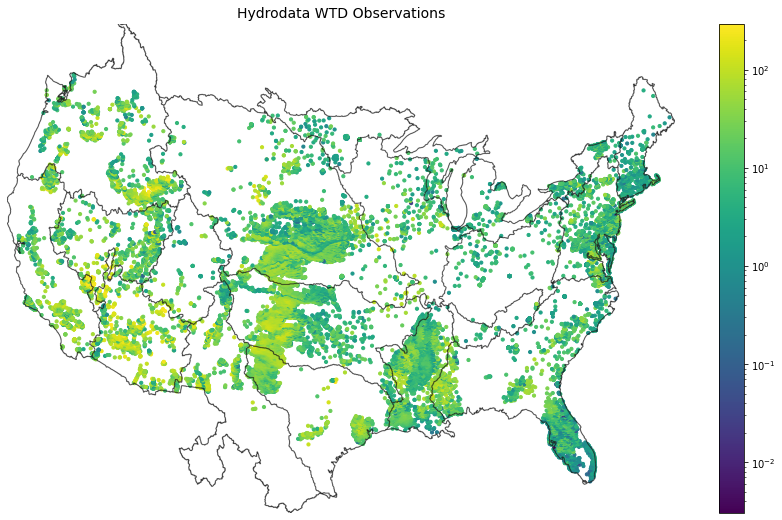

In [81]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(metadata.conus2_x,metadata.conus2_y, c=obs.wtd, norm=mpl.colors.LogNorm(), zorder=1, s=10) #
plt.title(f'Hydrodata WTD Observations', fontsize=14)
plt.colorbar(points)
plt.axis('off')
# plt.savefig(f'{plot_dir}/{summary_plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

(0.0, 4442.0, 0.0, 3256.0)

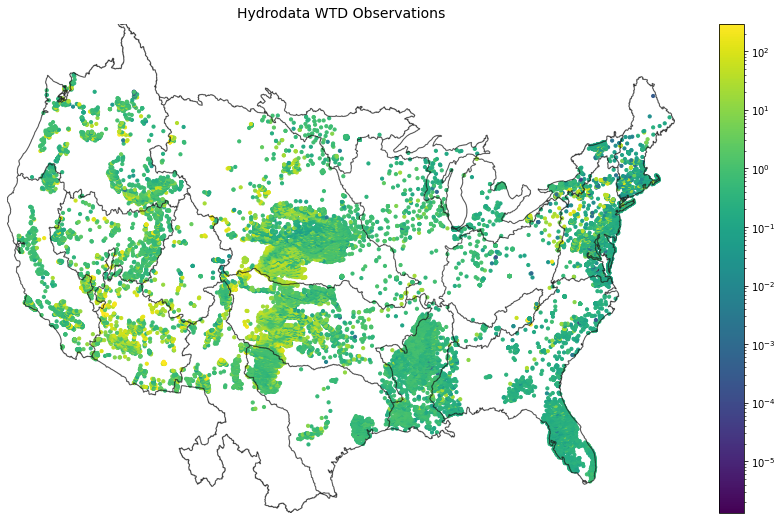

In [82]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(metadata.conus2_x,metadata.conus2_y, c=pf_wtd_matched.wtd, norm=mpl.colors.LogNorm(), zorder=1, s=10) #
plt.title(f'PF-CONUS2 Average WTD', fontsize=14)
plt.colorbar(points)
plt.axis('off')
# plt.savefig(f'{plot_dir}/{summary_plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
  

ValueError: 'c' argument has 14463152 elements, which is inconsistent with 'x' and 'y' with size 33398.

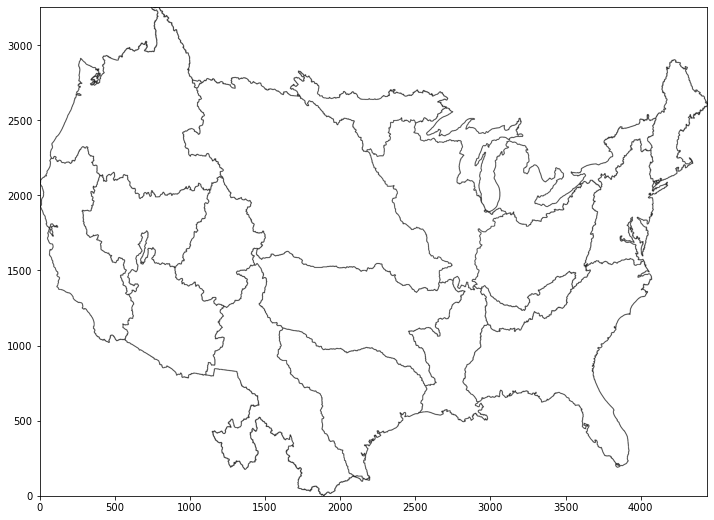

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(metadata.conus2_x,metadata.conus2_y, c=longTermMean, norm=mpl.colors.LogNorm(), zorder=1, s=10) #
plt.title(f'Gridded Obs Average WTD - Yueling', fontsize=14)
plt.colorbar(points)
plt.axis('off')
# plt.savefig(f'{plot_dir}/{summary_plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
  

In [ ]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, zorder=1, s=30, vmax = 1, vmin = -1) #
plt.title(f'SNOTEL-CW3E {variable} absolute relative bias, WY{water_year}', fontsize=14)
plt.colorbar(points)
plt.axis('off')
# plt.savefig(f'{plot_dir}/{summary_plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

In [ ]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, zorder=1, s=30, vmax = 1, vmin = -1) #
plt.title(f'SNOTEL-CW3E {variable} absolute relative bias, WY{water_year}', fontsize=14)
plt.colorbar(points)
plt.axis('off')
plt.title(f'SNOTEL-CW3E {variable} relative bias, WY{water_year}')
# plt.savefig(f'{plot_dir}/{summary_plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_RelBias_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,9))
im = ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, zorder=1, s=30, vmax = 1, vmin = -1) #
plt.title(f'SNOTEL-CW3E {variable} absolute relative bias, WY{water_year}', fontsize=14)
plt.colorbar(points)
plt.axis('off')
plt.title(f'SNOTEL CW3E {variable} Srho, WY{water_year}')
# plt.savefig(f'{plot_dir}/WY{water_year}_SNOTEL_CW3E_{variable}_SpearmansRho_Map.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

In [93]:
fig, [ax1] = plt.subplots(1,1,figsize=(),constrained_layout=True)

# #Scatter plot
# ax1.scatter(WTD_data[~np.isnan(WTD_data)],WTD_estimates[~np.isnan(WTD_data)],s=1,c='b')
# ax1.plot(range(301),range(301),'r--',lw=2)
# ax1.set_xlabel('Observed WTD [m]',fontsize=12)
# ax1.set_ylabel('Estimated WTD [m]',fontsize=12)
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_xlim(0.1,300)
# ax1.set_title('(A)',loc='left',fontsize=12)
# ax1.tick_params(axis='both',labelsize=12)

TypeError: from_bounds() missing 2 required positional arguments: 'width' and 'height'

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xscale'

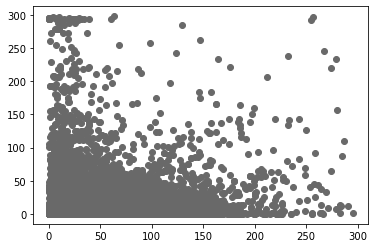

In [88]:
plt.scatter(obs_data_new.wtd, pf_match_df_new.wtd, color = 'dimgrey')
plt.set_xscale('log')
plt.set_yscale('log')

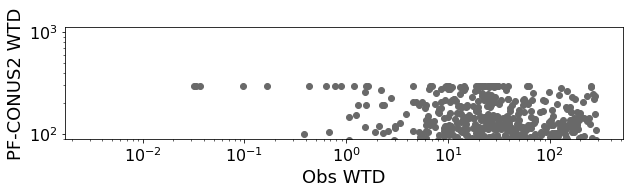

In [54]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

#ax.scatter(stats_df['SNOTEL_meanTotal_P_mm'], stats_df['CW3E_meanTotal_P_mm'], color = 'dimgrey')
ax.scatter(obs_data_new.wtd, pf_match_df_new.wtd, color = 'dimgrey')
#ax.scatter(longTermMean,annual_mean, color = 'dimgrey')
#ax.plot(range(300), color = 'lightcoral')
plt.ylabel('PF-CONUS2 WTD',fontsize=18)
plt.xlabel('Obs WTD',fontsize=18) #from hydrodata
#plt.title('Daily total precipitation comparison, WY2003',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# # square plot
ax.set_aspect('equal', adjustable='box')
#plt.savefig(f'{plot_dir}/{summary_plot_dir}/SNOTEL_CW3E_totalPrecip_scatter_WY{water_year}.png')


(0.0, 300.0)

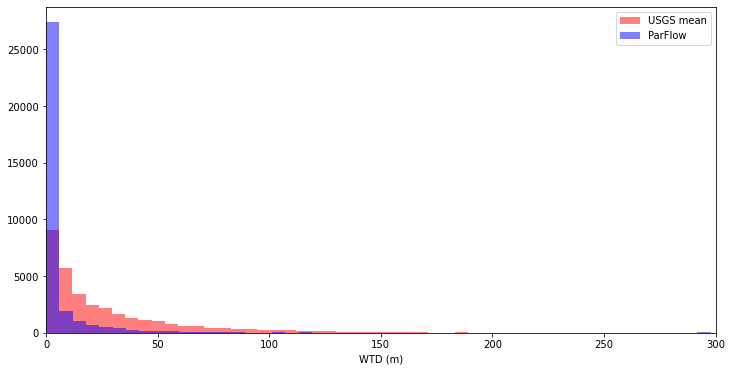

In [71]:
plt.figure(figsize=(12,6))
plt.hist(obs_data_new.wtd, bins = 50, color='r',alpha=0.5, label='USGS mean')
plt.hist(pf_match_df_new.wtd, bins = 50, color='b',alpha=0.5, label='ParFlow')
plt.xlabel('WTD (m)')
plt.legend()
plt.xlim(0,300)
# plt.savefig('histogram_domain_USGS.png', dpi=300)

In [56]:
len(obs_data_new)

33398

In [57]:
longTermMean = np.squeeze(read_pfb(f'{organized_dir}/gridded_WTD_mean_obs_CONUS2.pfb'))

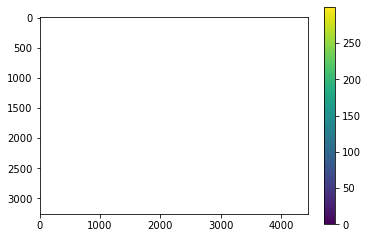

In [69]:
plt.imshow(longTermMean)
plt.colorbar()

In [67]:
np.nanmax(longTermMean)

299.9854433684211

In [68]:
longTermMean

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [60]:
annual_mean1 = np.copy(annual_mean)

In [61]:
annual_mean1 = annual_mean[np.where(np.isnan(longTermMean)) == 'nan']

In [62]:
grid_diff = annual_mean1-longTermMean

(0.1, 300)

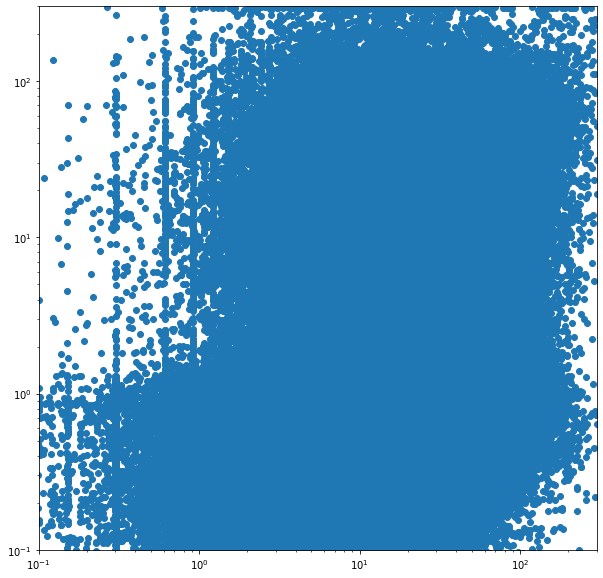

In [63]:
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(longTermMean,annual_mean)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,300)
ax.set_ylim(0.1,300)

In [64]:
diff = annual_mean-longTermMean

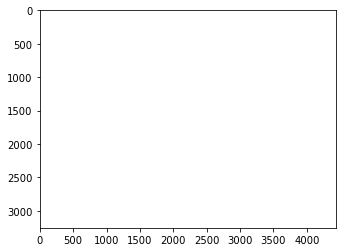

In [65]:
plt.imshow(diff)

In [88]:
annual_mean.max()

300.41651749541745

In [95]:
np.nanmax(longTermMean)

299.9854433684211

In [84]:
#CONUS2 steady state water table depth from Chen
C2_wtd = np.load('/home/dtt2/GW_Pumping/wtdepth3.npy')

In [85]:
C2_wtd.shape

(3256, 4442)

In [94]:
np.nanmax(C2_wtd)

300.4160091059641

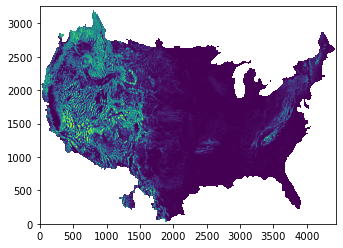

In [126]:
plt.imshow(C2_wtd, origin='lower')

In [106]:
# difference between transient and steady state WTD
# I DON'T KNOW IF CHEN AVERAGED THE WTD (or exactly what she did) BUT THIS IS A COMPARISON TO ANNUAL AVERAGE CONUS2 WTD
CONUS2_diff = annual_mean-C2_wtd

Text(0.5, 1.0, 'CONUS2 Transient Annual Mean minus Steady State WTD')

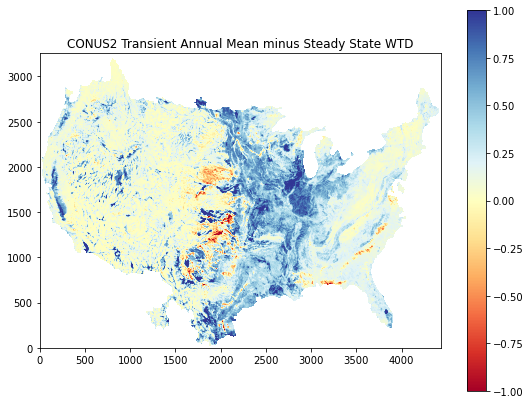

In [125]:
plt.figure(figsize = (9,7))
plt.imshow(CONUS2_diff, origin='lower',vmin= -1, vmax = 1, interpolation=None, cmap='RdYlBu')
plt.colorbar()
plt.title('CONUS2 Transient Annual Mean minus Steady State WTD')

In [112]:
np.nanmax(CONUS2_diff)
np.nanmin(CONUS2_diff)

-58.26426305676824

In [114]:
np.nanmean(CONUS2_diff)

0.23993440239283184

In [5]:
obs_wtds = np.load('/home/dtt2/CONUS2/Chen_WTD_CONUS2-validation/npy/obs_wtds.npy')

In [8]:
obs_wtds

array([0.08903368, 0.36646216, 0.804672  , ..., 6.54580698, 6.3915263 ,
       7.0254368 ])